<a href="https://colab.research.google.com/github/MuellerLeonard/Skip-Gram_fastText/blob/master/Environment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-gpu
!pip install keras
!pip install requests

     |████████████████████████████████| 516.2MB 32kB/s 


Needed classes for imports

cleanup.py

In [ ]:
import re
import string
from typing import List
import nltk
from nltk import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')

def clean_text(tweets: List[str], lang: str = 'english') -> List[str]:
    """
    performes stemming and other "cleanup"
    :param tweets:
    :param lang:
    :return:
    """

    data: List[str] = tweets
    cleaned_text = []
    stops = set(stopwords.words(lang))

    # no ! and .
    table = str.maketrans(dict.fromkeys(""""#$%&()*+,-/:;<=>?@[\\]^_`{|}~"""))

    for text in data:
        text = re.sub(r'https?://[^\s]*', ' tokenlink ', text)
        text = re.sub(r'\.\.\.', ' tokendotdotdot ', text)
        text = re.sub(r'xD', ' tokenxd ', text)
        text = re.sub(r':\)', ' tokenxbrackethappy ', text)
        text = re.sub(r':\(', ' tokenxbracketsad ', text)
        text = re.sub(r':-\)', ' tokennosehappy ', text)
        text = re.sub(r':-\(', ' tokennosesad ', text)
        text = re.sub(r':D', ' tokenxcheer ', text)
        text = re.sub(r':-S', ' tokens ', text)


        ## Convert words to lower case and split them
        text = text.lower().split()

        text = " ".join(text)

        # Clean the text
        text = re.sub(r"(?<!\.)\.(?!\.)", " ", text)
        text = re.sub(r"[^A-Za-z0-9^,!./'+-=]", " ", text)
        text = re.sub(r"what's", "what is ", text)
        text = re.sub(r"\'s", " ", text)
        text = re.sub(r"\'ve", " have ", text)
        text = re.sub(r"n't", " not ", text)
        text = re.sub(r"i'm", "i am ", text)
        text = re.sub(r"\'re", " are ", text)
        text = re.sub(r"\'d", " would ", text)
        text = re.sub(r"\'ll", " will ", text)
        text = re.sub(r",", " ", text)
        text = re.sub(r"\.", " ", text)
        text = re.sub(r"!", " ! ", text)
        text = re.sub(r"/", " ", text)
        text = re.sub(r"\^", " ^ ", text)
        text = re.sub(r"\+", " + ", text)
        text = re.sub(r"-", " - ", text)
        text = re.sub(r"=", " = ", text)
        text = re.sub(r"'", " ", text)
        text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
        text = re.sub(r":", " : ", text)
        text = re.sub(r" e g ", " eg ", text)
        text = re.sub(r" b g ", " bg ", text)
        text = re.sub(r" u s ", " american ", text)
        text = re.sub(r"\0s", "0", text)
        text = re.sub(r" 9 11 ", "911", text)
        text = re.sub(r"e - mail", "email", text)
        text = re.sub(r"j k", "jk", text)
        text = re.sub(r"\s{2,}", " ", text)

        ## Remove puncuation
        text = text.translate(table)

        text = text.split()

        ## Remove stop words[^\s][^\s]
        #text = [w for w in text if not w in stops]

        stemmer = SnowballStemmer(lang)
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
        cleaned_text.append(text)

    return cleaned_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


NBT.py

In [ ]:
from google.colab import files
amazon_Surf_L10_mat = files.upload()
dslr_Surf_L10_mat = files.upload()

Saving amazon_SURF_L10.mat to amazon_SURF_L10.mat


Saving dslr_SURF_L10.mat to dslr_SURF_L10.mat


In [ ]:
import numpy as np
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
class NBT():
    """
    Nyström Basis Transfer Service Class
    Published in:
    Christoph Raab, Frank-Michael Schleif,
    Transfer learning extensions for the probabilistic classification vector machine,Neurocomputing,2019,
    https://doi.org/10.1016/j.neucom.2019.09.104.
    Functions
    ----------
    nys_basis_transfer: Transfer Basis from Target to Source Domain.
    data_augmentation: Augmentation of data by removing or upsampling of source data
    Examples
    --------
    >>> #Imports
    >>> import os
    >>> import scipy.io as sio
    >>> from sklearn.svm import SVC
    >>> os.chdir(os.path.dirname(os.path.abspath(__file__)))
    >>> os.chdir(os.path.join("datasets","domain_adaptation","features","OfficeCaltech"))
    >>> amazon = sio.loadmat("amazon_SURF_L10.mat")
    >>> X = preprocessing.scale(np.asarray(amazon["fts"]))
    >>> Yt = np.asarray(amazon["labels"])
    >>>
    >>> dslr = sio.loadmat("dslr_SURF_L10.mat")
    >>>
    >>> Z = preprocessing.scale(np.asarray(dslr["fts"]))
    >>> Ys = np.asarray(dslr["labels"])
    >>>
    >>> clf = SVC(gamma=1,C=10)
    >>> clf.fit(Z,Ys)
    >>> print("SVM: "+str(clf.score(X,Yt)))
    >>>
    >>> nbt = NBT()
    >>> Ys,Z = nbt.data_augmentation(Z,X.shape[0],Ys)
    >>> X,Z = nbt.nys_basis_transfer(X,Z,Ys.flatten(),landmarks=100)
    >>> clf = SVC(gamma=1,C=10)
    >>> clf.fit(Z,Ys)
    >>> print("SVM + NBT: "+str(clf.score(X,Yt)))
    """

    def __init__(self,landmarks=10):
        self.landmarks = landmarks
        pass

    def nys_basis_transfer(self,X,Z,Ys=None):
        """
        Nyström Basis Transfer
        Transfers Basis of X to Z obtained by Nyström SVD
        Implicit dimensionality reduction
        Applications in domain adaptation or transfer learning
        Parameters.
        Note target,source are order sensitiv.
        ----------
        X : Target Matrix, where classifier is trained on
        Z : Source Matrix, where classifier is trained on
        Ys: Source data label, if none, classwise sampling is not applied.
        landmarks : Positive integer as number of landmarks
        Returns
        ----------
        X : Reduced Target Matrix
        Z : Reduced approximated Source Matrix
        """
        if type(X) is not np.ndarray or type(Z) is not np.ndarray:
            raise ValueError("Numpy Arrays must be given!")
        if type(self.landmarks ) is not int or self.landmarks  < 1:
            raise ValueError("Positive integer number must given!")
        landmarks = np.min([X.shape[0]]+[Z.shape[0]]+[self.landmarks ])
        max_idx = np.min(list(X.shape)+list(Z.shape))
        idx = np.random.randint(0,max_idx-1,landmarks)
        A = X[np.ix_(idx,idx)]
        # B = X[0:landmarks,landmarks:]
        F = X[landmarks:,0:landmarks]
        #C = X[landmarks:,landmarks:]
        U, S, H = np.linalg.svd(A, full_matrices=True)
        S = np.diag(S)

        U_k = np.concatenate([U,(F @H )@np.linalg.pinv(S)])
        #V_k = np.concatenate([H, np.matmul(np.matmul(B.T,U),np.linalg.pinv(S))])
        X = U_k @S

        if type(Ys) is np.ndarray:
            A = self.classwise_sampling(Z,Ys,landmarks)
        else:
            A = Z[np.ix_(idx,idx)]

        D = np.linalg.svd(A, full_matrices=True,compute_uv=False)
        Z = U_k @ np.diag(D)
        return preprocessing.scale(X),preprocessing.scale(Z)

    def classwise_sampling(self,X,Y,n_landmarks):

        A = []
        classes = np.unique(Y)
        c_classes = classes.size
        samples_per_class = int(n_landmarks / c_classes)
        for c in classes:
            class_data = X[np.where(c == Y)]

            if samples_per_class > class_data.shape[0]:
                A = A+list(class_data)
            else:
                A = A+list(class_data[np.random.randint(0,class_data.shape[0],samples_per_class)])

        return np.array(A)

    def basis_transfer(self,X,Z):
        """
         Basis Transfer
        Transfers Basis of X to Z obtained by Nyström SVD
        Applications in domain adaptation or transfer learning
        Parameters.
        Note target,source are order sensitiv.
        ----------
        X : Target Matrix, where classifier is trained on
        Z : Source Matrix, where classifier is trained on
        Returns
        ----------
        Z : Transferred Source Matrix
        """
        L,S,R = np.linalg.svd(X,full_matrices=False);
        D = np.linalg.svd(Z,compute_uv=False,full_matrices=False)
        return L @ np.diag(D) @ R

    def fit_predict(self, Xs, Ys, Xt, Yt):
        '''
        Fit and use 1NN to classify
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt: nt * n_feature, target feature
        :param Yt: nt * 1, target label
        :return: Accuracy, predicted labels of target domain, and G
        '''
        clf = KNeighborsClassifier(n_neighbors=1)
        clf.fit(Xs, Ys.ravel())
        y_pred = clf.predict(Xt)
        acc = np.mean(y_pred == Yt.ravel())
        return acc, y_pred


    def data_augmentation(self,Z,required_size,Y):
        """
        Data Augmentation
        Upsampling if Z smaller as required_size via multivariate gaussian mixture
        Downsampling if Z greater as required_size via uniform removal
        Note both are class-wise with goal to harmonize class counts
        ----------
        Z : Matrix, where classifier is trained on
        required_size : Size to which Z is reduced or extended
        Y : Label vector, which is reduced or extended like Z
        Returns
        ----------
        X : Augmented Z
        Z : Augmented Y
        """
        if type(Z) is not np.ndarray or type(required_size) is not int or type(Y) is not np.ndarray:
            raise ValueError("Numpy Arrays must be given!")
        if Z.shape[0] == required_size:
            return Y,Z
        
        _, idx = np.unique(Y, return_index=True)
        C = Y[np.sort(idx)].flatten().tolist()
        size_c = len(C)
        if Z.shape[0] < required_size:
            print("Source smaller target")
            data = np.empty((0,Z.shape[1]))
            label = np.empty((0,1))
            diff = required_size - Z.shape[0]
            sample_size = int(np.floor(diff/size_c))
            for c in C:
                #indexes = np.where(Y[Y==c])
                indexes =  np.where(Y==c)
                class_data = Z[indexes,:][0]
                m = np.mean(class_data,0) 
                sd = np.var(class_data,0)
                sample_size = sample_size if c !=C[-1] else sample_size+np.mod(diff,size_c)
                augmentation_data =np.vstack([np.random.normal(m, sd, size=len(m)) for i in range(sample_size)])
                data =np.concatenate([data,class_data,augmentation_data])
                label = np.concatenate([label,np.ones((class_data.shape[0]+sample_size,1))*c])
            
        if Z.shape[0] > required_size:
            print("Source greater target")
            data = np.empty((0,Z.shape[1]))
            label = np.empty((0,1))
            sample_size = int(np.floor(required_size/size_c))
            for c in C:
                indexes = np.where(Y[Y==c])[0]
                class_data = Z[indexes,:]
                if len(indexes) > sample_size:
                    sample_size = sample_size if c !=C[-1] else np.abs(data.shape[0]-required_size)
                    y = np.random.choice(class_data.shape[0],sample_size)
                    class_data = class_data[y,:]
                data =np.concatenate([data,class_data])
                label = np.concatenate([label,np.ones((class_data.shape[0],1))*c])
        Z = data
        Y = label
        return Y,Z

if __name__ == "__main__":

    import os
    import scipy.io as sio
    from sklearn.svm import SVC

    # Load and preprocessing of data. Note normalization to N(0,1) is necessary.
    # not needed files were directly accessed
    # os.chdir("datasets/domain_adaptation/OfficeCaltech/features/Surf")
    amazon = sio.loadmat("amazon_SURF_L10.mat")
    X = preprocessing.scale(np.asarray(amazon["fts"]))
    Yt = np.asarray(amazon["labels"])

    dslr = sio.loadmat("dslr_SURF_L10.mat")

    Z = preprocessing.scale(np.asarray(dslr["fts"]))
    Ys = np.asarray(dslr["labels"])

    # Applying SVM without transfer learning. Accuracy should be about 10%
    clf = SVC(gamma=1,C=10)
    clf.fit(Z,Ys)
    print("SVM without transfer "+str(clf.score(X,Yt)))

    # Beginning of NBT. Accuracy of SVM + NBT should be about 90%
    nbt = NBT(landmarks=100)
    # Data augmentation is necessary if Z and X have different shapes.
    Ys,Z = nbt.data_augmentation(Z,X.shape[0],Ys)
    X,Z = nbt.nys_basis_transfer(X,Z,Ys.flatten())
    clf = SVC(gamma=1,C=10)
    clf.fit(Z,Ys)
    print("SVM + NBT: "+str(clf.score(X,Yt)))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM without transfer 0.10438413361169102
Source smaller target


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM + NBT: 0.9311064718162839


Download Datasets

Tweets.csv Dataset to big |
Test if sentqs_dataset.npz works

In [ ]:
import requests
import sys

#Download Links

linkTweets = "https://raw.githubusercontent.com/ChristophRaab/NASDAQ-Dataset/master/Tweets.csv"
file_nameT = "Tweets.csv"
link = "https://cloud.fhws.de/index.php/s/M4rkbHj9FfW6YKo/download"
file_name = "sentqs_dataset.npz"
# linkGlove = "https://www.kaggle.com/fullmetal26/glovetwitter27b100dtxt/download" --> still has to be unzipped
# file_nameG = "glove.twitter.27B.200d.txt"
# linkDataset = "https://cloud.fhws.de/index.php/s/M4rkbHj9FfW6YKo/download"
# file_nameD = sentqs_dataset.npz

rT = requests.get(linkTweets, allow_redirects=True)
open(file_nameT, 'wb').write(rT.content)

with open(file_name, "wb") as f:
            print("Downloading %s" % file_name)
            response = requests.get(link, stream=True)
            total_length = response.headers.get('content-length')

            if total_length is None: # no content length header
                f.write(response.content)
            else:
                dl = 0
                total_length = int(total_length)
                for data in response.iter_content(chunk_size=4096):
                    dl += len(data)
                    f.write(data)
                    done = int(50 * dl / total_length)
                    sys.stdout.write("\r[%s%s]" % ('=' * done, ' ' * (50-done)) )
                    sys.stdout.flush()

# !wget https://www.kaggle.com/fullmetal26/glovetwitter27b100dtxt/download
# !unzip glove.twitter.27B.200d.txt.zip
# rG = requests.get(linkGlove, allow_redirects=True)
# open(file_nameG, 'wb').write(rG.content)

[==================================================]

Only for testing: Glove.txt

In [ ]:
from google.colab import files
uploadGlove = files.upload() 

Saving glove.short.txt to glove.short.txt


In [ ]:
from google.colab import files
uploadTweets = files.upload()

Saving Tweets_short.csv to Tweets_short.csv


sentqs_preprocess.py

                                                        0    1
count                                                 101  101
unique                                                100   13
top     googl tokendotdotdot what can i say ! ! e stoc...   10
freq                                                    2   25
Class Counts:


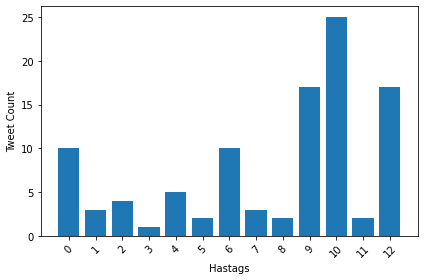

['embedding']


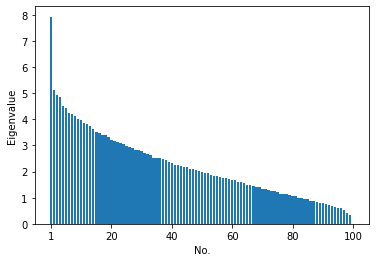

Starting TSNE

Finished TSNE

Finished TSNE

Finished TSNE

Finished TSNE

Finished TSNE



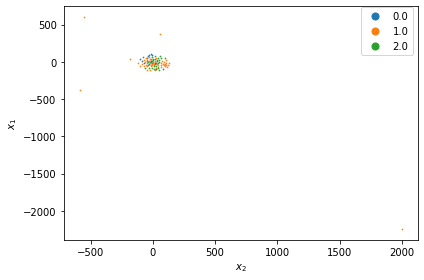

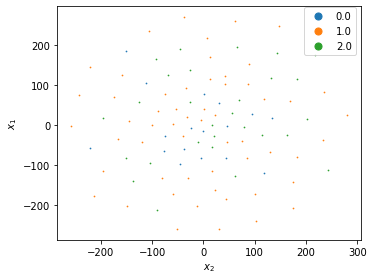

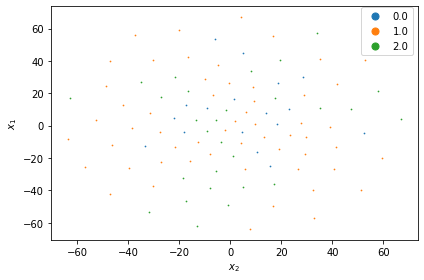

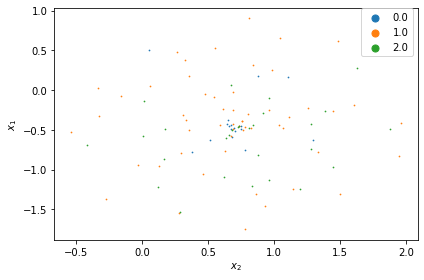

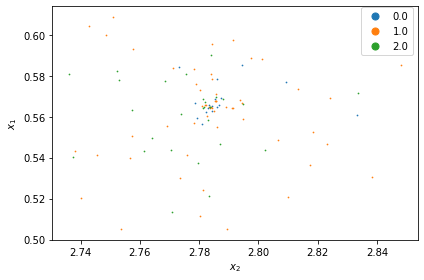

In [ ]:
import scipy.io as sio
import pandas as pd
import numpy as np
import os
from sklearn import preprocessing
# import cleanup --> already in notebook
import keras
from sklearn.feature_extraction.text import TfidfVectorizer
#from tensorflow.keras.layers import Dense, Embedding, Flatten, Input, Conv1D, GlobalMaxPooling1D, MaxPooling1D
from keras.utils import np_utils
from tensorflow.keras.preprocessing.sequence import skipgrams, pad_sequences
from sklearn.manifold import TSNE
from tensorflow.keras.models import Sequential
from sklearn import decomposition
#from keras_preprocessing.text import Tokenizer
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import make_sampling_table
from numpy import asarray, zeros
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling3D, GlobalMaxPooling2D, MaxPooling2D, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.layers import Conv2D, Conv3D, Conv2D, MaxPooling3D, Embedding, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Constant
# from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import plot_model
from scipy import spatial
from gensim.models import Word2Vec
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import concatenate
from tensorflow.keras import backend
import tensorflow as tf

def load_data_run_classification():
  # data/
    data = np.load('sentqs_dataset.npz')
    Xs = data["arr_0"]
    Ys = data["arr_1"]
    Xt = data["arr_2"]
    Yt = data["arr_3"]
    print("Classification Task Test \n")
    from sklearn.ensemble import GradientBoostingClassifier
    clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(Xs, Ys)
    print(clf.score(Xt, Yt))

def create_tfidf(sen,min_df=10,max_df=100):
    print("Create TF-IDF\n")
    vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df)
    X = vectorizer.fit_transform(sen)
    return X.toarray()

def save_dataset(X, y, prefix =""):
    print("Save Dataset \n")
    y = np.array(y)[:, None]
    dataset = np.concatenate([y,X], axis=1)

    # data/
    np.save("sentqs_da_"+str(prefix)+".npy",dataset)
    return dataset

def seperate_tweets(data,hashtags,sentiment):
    print("Seperate Tweets \n")
    labels = []
    tweets = []
    sentiment_new = []
    for t,s in zip(data,sentiment):
        for h in hashtags:
            t = t.lower()
            h = "#" + h.lower()
            if h in t:
                labels.append(h)
                tweets.append(t.replace(h," "))
                sentiment_new.append(s)
                break

    return labels,tweets,sentiment_new

def generate_data(corpus, window_size, V):
    for words in corpus:
        couples, labels = skipgrams(words, V, window_size, negative_samples=1, shuffle=True,sampling_table=make_sampling_table(V, sampling_factor=1e-05))
        if couples:
            X, y = zip(*couples)
            X = np_utils.to_categorical(X, V)
            y = np_utils.to_categorical(y, V)
            yield X, y

def get_glove_embedding_matrix(texts, dim=200):
    # data/
    if os.path.isfile("sentqs_glove_embedding.npz"):
      # data/
        loaded_embedding = np.load("sentqs_glove_embedding.npz")
        print('Loaded Glove embedding.')
        return loaded_embedding['embedding']
    else:
        # first, build index mapping words in the embeddings set
        # to their embedding vector

        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(texts)
        sequences = tokenizer.texts_to_sequences(texts)

        word_index = tokenizer.word_index

        print('Indexing word vectors.')

        embeddings_index = {}
        # data/
        # evtl. größeren Datensatz wenn möglich verwenden
        with open('glove.short.txt', encoding="utf8") as f:
            for line in f:
                word, coefs = line.split(maxsplit=1)
                coefs = np.fromstring(coefs, 'f', sep=' ')
                embeddings_index[word] = coefs

        print('Found %s word vectors.' % len(embeddings_index))
        print('Preparing embedding matrix.')

        # prepare embedding matrix
        num_words = len(word_index) + 1
        embedding_matrix = np.zeros((num_words, dim))
        counter = 0
        for word, i in word_index.items():
            # if i >= MAX_NUM_WORDS:
            #    counter +=1
            #    continue
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # words not found in embedding index will be all-zeros.
                embedding_matrix[i] = embedding_vector

        # data/
        np.savez_compressed("sentqs_glove_embedding.npz", embedding=embedding_matrix)
        return embedding_matrix

# epochs 100 to 10
# batch_size, epochs je nach Menge an Daten die eingespeißt werden
def get_skipgram_sentence_embedding_matrix(text, dim=200, batch_size=2, window_size=5, epochs = 1):
  # data/
    if os.path.isfile("sentqs_skipgram_sentence_embedding.npz"):
      # data/
        loaded_embedding = np.load("sentqs_skipgram_sentence_embedding.npz")
        loaded_embedding = loaded_embedding["embedding"]
        print('Loaded Skipgram embedding.')
        return loaded_embedding
    else:
        text = [''.join(x) for x in text]
        t = Tokenizer()
        t.fit_on_texts(text)
        corpus = t.texts_to_sequences(text)
        print(corpus)
        V = len(t.word_index)
        step_size = len(corpus) // batch_size
        model = Sequential()
        model.add(Dense(dim, input_dim=V, activation="softmax"))
        model.add(Dense(V, input_dim=dim, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
        model.summary()

        model.fit(generate_data(corpus, window_size, V), epochs=epochs, steps_per_epoch=step_size)
        # model.save("data/sentqs_full_skigram_arc.h5")
        mlb = MultiLabelBinarizer()
        print("step 1")
        enc = mlb.fit_transform(corpus)
        print("step 2")
        emb = enc @ model.get_weights()[0]
        # data/
        np.savez_compressed("sentqs_skipgram_sentence_embedding", embedding=emb)
        return emb

def  get_skipgram_gensim_embedding_matrix(text, dim = 200, window_size=5, min_word_occurance=1, epochs=1):
  # data/
    if os.path.isfile("sentqs_skipgram_gensim_embedding.npz"):
      # data/
        loaded_embedding = np.load("sentqs_skipgram_gensim_embedding.npz")
        loaded_embedding = loaded_embedding["embedding"]
        print('Loaded Skipgram embedding.')
        return loaded_embedding
    else:
        x = [row.split(' ') for row in text]
        model = Word2Vec(x, size=dim, window=window_size, min_count=min_word_occurance, workers=4, sg=1) #sg = 1: use skipgram

        words = model.wv.vocab.keys()
        vocab_size = len(words)
        print("Vocab size", vocab_size)

        t = Tokenizer()
        t.fit_on_texts(text)

        # total vocabulary size plus 0 for unknown words
        # vocab_size = len(vocab) + 1
        # define weight matrix dimensions with all 0
        weight_matrix = zeros((vocab_size, dim))
        # step vocab, store vectors using the Tokenizer's integer mapping
        for word, i in t.word_index.items():
            if i > vocab_size: break
            if word in model.wv.vocab.keys():
                weight_matrix[i] = model.wv[word]

        # data/
        np.savez_compressed("sentqs_skipgram_gensim_embedding", embedding=weight_matrix)
        return weight_matrix

def generate_embedding_model(text, y,source_idx,target_idx,batch_size=32, epochs = 50, save = True, dim = 200, val_split=0.2,model_size="medium"):
    # Preprocessing
    #MAX_SEQUENCE_LENGTH = len(max(text, key=lambda i: len(i))) + 1
    MAX_SEQUENCE_LENGTH = 335
    texts = [''.join(x) for x in text]
    # finally, vectorize the text samples into a 2D integer tensor
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)

    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

    labels = to_categorical(np.asarray(y))
    print('Shape of data tensor:', data.shape)
    print('Shape of label tensor:', labels.shape)
    num_words = len(word_index) + 1

    # split the data into a training set and a validation set
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    data = data[indices]
    labels = labels[indices]
    num_validation_samples = int(val_split * data.shape[0])

    x_train = data[source_idx]
    y_train = labels[source_idx]
    x_val = data[target_idx]
    y_val = labels[target_idx]

    emb = get_skipgram_gensim_embedding_matrix(text, epochs=1)
    emb = np.expand_dims(emb, 1)
    emb_train = emb[:-num_validation_samples]
    emb_val = emb[-num_validation_samples:]
    # Build model
    MAX_SEQUENCE_LENGTH = len(max(text, key=lambda i: len(i))) + 1
    with tf.device('/GPU:0'):
        sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32',name="embedding_input")

        glove_embedding_layer = Embedding(num_words,
                                    dim,
                                    weights=[get_glove_embedding_matrix(texts, dim)],
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=False)(sequence_input)
        skipgram_embedding_layer = Embedding(num_words,
                                    dim,
                                    weights=[get_skipgram_gensim_embedding_matrix(texts, dim)],
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=False)(sequence_input)

        if model_size =="medium":

            combined=  tf.keras.layers.Lambda(lambda t: tf.stack(t,axis=3))([skipgram_embedding_layer, glove_embedding_layer])
            x = Conv2D(128, 5, activation='relu')(combined)
            x = MaxPooling2D(5)(x)
            x = Conv2D(128, 5, activation='relu')(x)
            x = MaxPooling2D(5)(x)
            x = Conv2D(128, 5, activation='relu')(x)
            x = GlobalMaxPooling2D()(x)
            x = Dense(128, activation='relu')(x)



        if model_size =="large":
            skipgram_sentence_embedding = Embedding(num_words,
                                    dim,
                                    #embeddings_initializer=Constant(get_skipgram_gensim_embedding_matrix(text, epochs=1)),
                                    #weights=get_skipgram_gensim_embedding_matrix(text, epochs=1),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=True)(sequence_input)

            combined = tf.keras.layers.Lambda(lambda t: tf.stack(t,axis=3))([skipgram_embedding_layer, glove_embedding_layer,skipgram_sentence_embedding])
            x = DenseNet121(include_top=False, weights=None, input_shape = (MAX_SEQUENCE_LENGTH, dim, 3))(combined)
            x = GlobalAveragePooling2D()(x)

        preds = Dense(3, activation='softmax')(x)
        model = Model(inputs=sequence_input, outputs=preds)
        model.compile(loss='categorical_crossentropy',
                    optimizer='rmsprop',
                    metrics=['acc'])

        model.summary()
        # plot_model(model, to_file='model_combined.png')

        # Train model
        model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_val, y_val))

        if save:
          # data/
            model.save("sentqs_full.h5")
        return model

def tsne_embedding(X):
    print("Starting TSNE\n")
    for p in [5,25,50,75,100]:
        tsne = TSNE(n_components=2, init='random',
             random_state=0, perplexity=p)
        xl = tsne.fit_transform(X)
        # data/
        np.save("sentqs_tsne_"+str(p)+".npy",xl)
        print("Finished TSNE\n")


def describe_dataset(tweets,labels):
    data = pd.DataFrame([tweets, labels]).T
    description = data.describe()
    print(description)

    print("Class Counts:")
    class_counts = data.groupby(1).size()

    x = class_counts.to_numpy()
    keys = class_counts.keys().to_list()
    fig, ax = plt.subplots()
    plt.bar(keys, x)
    plt.ylabel("Tweet Count")
    plt.xticks(range(len(keys)), keys, rotation=45)
    plt.xlabel("Hastags")
    plt.tight_layout()
    # plots/
    plt.savefig("sentqs_class_dist.pdf", dpi=1000, transparent=True)
    plt.show()

def plot_eigenspectrum(x):
    values = np.linalg.svd(x,compute_uv=False)
    plt.bar(range(101), values[:101], align='center')
    plt.ylabel("Eigenvalue")
    # plt.tight_layout()
    plt.xlabel("No.")
    plt.xticks([0, 20, 40, 60, 80, 100], [1, 20, 40, 60, 80, 100])
    # plots/
    plt.savefig("sentqs_spectra.pdf", transparent=True)
    plt.show()


def plot_tsne(X:None,labels):
    tsne_embedding(X)

    y = preprocessing.LabelEncoder().fit_transform(labels)
    for p in [5, 25, 50, 75, 100]:
      # data/
        d = np.load("sentqs_tsne_" + str(p) + ".npy")
        for idx, l in enumerate(list(set(labels))):
            c = np.where(y == idx)[0]
            x = d[c, :]
            plt.scatter(x[:, 0], x[:, 1], s=.5, label=l)
            plt.legend(markerscale=10., bbox_to_anchor=(1, 1.02))
        plt.ylabel("$x_1$")
        plt.xlabel("$x_2$")
        plt.tight_layout()
        # plots/
        plt.savefig('sentqs_tsne_plot_' + str(p) + ".pdf", dpi=1000, transparent=True)
        plt.show()

def create_domain_adaptation_dataset(X,tweets,source_idx,target_idx,sentiment):

    Xs = X[source_idx]
    Xt = X[target_idx]
    Ys = sentiment[source_idx]
    Yt = sentiment[target_idx]
    data = [Xs,Ys,Xt,Yt]
    # data/
    np.savez('sentqs_dataset.npz', *data)
    # data/
    sio.savemat('sentqs_dataset.mat', {'Xs': Xs, 'Xt': Xt, 'Ys': Ys, 'Yt': Yt})
    source_tweets = [tweets[i] for i in source_idx]
    target_tweets = [tweets[i] for i in target_idx]

    # data/
    pd.DataFrame(source_tweets).to_csv("sentqs_source_tweets.csv")
    # data/
    pd.DataFrame(target_tweets).to_csv("sentqs_target_tweets.csv")
    return  Xs,Ys,Xt,Yt

def load_sentqs_tweets():
  # data/
    if os.path.isfile("sentqs_preprocessed.npz"):
      # data/
        loaded_data = np.load("sentqs_preprocessed.npz")
        return loaded_data['cleaned_tweets'],loaded_data["tweets"], loaded_data['y'],loaded_data['sentiment'],loaded_data["source_idx"],loaded_data["target_idx"]
    else:
        hashtags = ['ADBE', 'GOOGL', 'AMZN', 'AAPL', 'ADSK', 'BKNG', 'EXPE', 'INTC', 'MSFT', 'NFLX', 'NVDA', 'PYPL', 'SBUX',
         'TSLA', 'XEL', 'positive', 'bad', 'sad']

        # Loading and preprocessing of tweets
        # only using a small parts of available Tweets to not overload the ram
        df = pd.read_csv("Tweets_short.csv")
        sentiment = pd.to_numeric(df.iloc[:, -1], errors="raise", downcast="float")
        labels,tweets,sentiment = seperate_tweets(df.iloc[:, 1],hashtags,sentiment)
        cleaned_tweets = clean_text(tweets)

        y = preprocessing.LabelEncoder().fit_transform(labels)

        source_idx,target_idx = create_domain_adaptation_index(tweets,labels,sentiment)
        # data/
        np.savez_compressed("sentqs_preprocessed.npz",tweets=tweets, cleaned_tweets=cleaned_tweets, y=y,sentiment=sentiment,source_idx=source_idx,target_idx=target_idx)
        return cleaned_tweets,tweets, y,sentiment,source_idx,target_idx

def create_domain_adaptation_index(tweets,labels,sentiment):
    labels = np.array([s if "#bad" not in s else "#sad" for s in labels])
    source_idx  = np.array([i for i,val in enumerate(labels) if val== "#sad" or val == "#bad" ])
    target_idx = np.array([i for i,val in enumerate(labels) if val != "#sad" and val != "#bad" ])
    return source_idx,target_idx


def main_preprocessing(mode="multi_semantic_embedding"):

    # Load neccessary informations about the dataset
    cleaned_tweets,tweets,hashtags,sentiment, source_idx, target_idx = load_sentqs_tweets()

    if mode == "multi_semantic_embedding":

        # Obtain embeddings and train deep learning model
        model = generate_embedding_model(cleaned_tweets,sentiment,source_idx,target_idx,model_size="medium")


    elif mode == "train_embedding":
        #Obtain skipgram embedding only
        #Create feature representation: TFIDF-Variants and skipgram embedding with 1000 dimension and negative sampling
        # Output will be saved to disk
        get_glove_embedding_matrix(cleaned_tweets)
        get_skipgram_gensim_embedding_matrix(cleaned_tweets)

        # Sentence Skipgram is the base feature representation of the datatset
        X = get_skipgram_sentence_embedding_matrix(cleaned_tweets)
        create_domain_adaptation_dataset(X,tweets,source_idx,target_idx,sentiment)
        # Another possible embedding:




    elif mode == "describe_dataset":
        # # Describe dataset with some common characteristics
        describe_dataset(cleaned_tweets,hashtags)

        # ## Plot eigenspectrum of embeddings
        #data/
        X = np.load("sentqs_skipgram_sentence_embedding.npz",allow_pickle=True)
        print(X.files)
        plot_eigenspectrum(X['embedding'])

        # ## Plot representation of 2 dimensional tsne embedding
        plot_tsne(X['embedding'],sentiment)

    else:
        ## Loads the data into the program and trains machine learning model
        load_data_run_classification()


if __name__ == '__main__':

    # Obtain the all files of the dataset preprocessing, including plots, feature representation etc.
    # After running this file you will find the corresponding files for classification in the data folder
    # select mode:
    main_preprocessing("describe_dataset")

sentqs_demo.py

In [ ]:
# Error: default_graph when using only keras and not tensorflow.keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D,Conv2D
from tensorflow.keras.datasets import imdb
import requests
import sys
import numpy as np
# from NBT import NBT --> already in notebook
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import preprocessing
link = "https://cloud.fhws.de/index.php/s/M4rkbHj9FfW6YKo/download"
# data/
file_name = "sentqs_dataset.npz"

def download_data():
    with open(file_name, "wb") as f:
            print("Downloading %s" % file_name)
            response = requests.get(link, stream=True)
            total_length = response.headers.get('content-length')

            if total_length is None: # no content length header
                f.write(response.content)
            else:
                dl = 0
                total_length = int(total_length)
                for data in response.iter_content(chunk_size=4096):
                    dl += len(data)
                    f.write(data)
                    done = int(50 * dl / total_length)
                    sys.stdout.write("\r[%s%s]" % ('=' * done, ' ' * (50-done)) )
                    sys.stdout.flush()

    data = np.load(file_name,allow_pickle=True)
    Xs = data["arr_0"]
    Ys = data["arr_1"]
    Xt = data["arr_2"]
    Yt = data["arr_3"]
    return Xs,Ys,Xt,Yt

#Xs,Ys,Xt,Yt = download_data()

#If dataset file is already downloaded
data = np.load(file_name,allow_pickle=True)
Xs = data["arr_0"]
Ys = data["arr_1"]
Xt = data["arr_2"]
Yt = data["arr_3"]

# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# Training
batch_size = 256
epochs = 2
# LSTM

lstm_output_size = 70
Xs = np.expand_dims(Xs, 2)
Xt = np.expand_dims(Xt, 2)


model = Sequential()
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(LSTM(lstm_output_size))
model.add(Dense(35))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# model.summary()
print('Train...')
model.fit(Xs, Ys,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(Xt, Yt))
score, acc = model.evaluate(Xt, Yt, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Train...
Epoch 1/2
1/1 [==============================] - 1s 636ms/step - loss: 0.7427 - accuracy: 0.0000e+00 - val_loss: 0.6817 - val_accuracy: 0.6806
Epoch 2/2
1/1 [==============================] - 0s 881us/step - loss: 0.6575 - accuracy: 0.6806
Test score: 0.6574681401252747
Test accuracy: 0.6805555820465088
